<a href="https://colab.research.google.com/github/ChiaraAngileri/-ingsw2022-AM06/blob/master/Lab/Lab5_Generative_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion Models
 Diffusion Models lie in the class of Explicit Density Models, since the density can be explicitely computed for this models, but the quality of their generation is impressive. Basically all the popoular software for image generation such as DALL-E and Midjourney are based on some variant of the diffusion models.
 

In [ ]:
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from keras import layers

import numpy as np

We need to import a dataset. As an example, we are going to use the Oxford Flower Dataset, a dataset which is built-in in Tensorflow, containing a large number of RGB images representing flowers.

To work with them, we first need to download the data from the tensorflow_datasets library. After that, we need to pre-process them to be 64x64x3 and, finally, we need to normalize them to be in the interval [0,1], as it is common when working with neural networks. This can be done by the following function

In [ ]:
def preprocess_image(data):
    # center crop image
    height = tf.shape(data["image"])[0]
    width = tf.shape(data["image"])[1]
    crop_size = tf.minimum(height, width)
    image = tf.image.crop_to_bounding_box(
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )

    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    image = tf.image.resize(image, size=[image_size, image_size], antialias=True)
    return tf.clip_by_value(image / 255.0, 0.0, 1.0)

Then, we can load the dataset from the tfds library. By calling the .map() method, we can also authomatically preprocess each image into the dataset with the function we just defined.

The dataset can be load with the function tfds.load(), that takes as input the name of the dataset and a string representing which part of the dataset to download, and returns a list whose first element is the TensorflowDataset object we are interested in. For computational reason, we also want to convert it into a numpy array.

We also want to setup some global parameters we will require in the following.

In [ ]:
def load_and_preprocess_dataset(dataset_name, split="train"):
    return np.array(list(tfds.load(dataset_name, shuffle_files=True, split=[split])[0].map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).repeat(5)))

# We consider the Oxford Flowers dataset. A dataset of 64 x 64 x 3 images.
dataset_name = "oxford_flowers102"
image_size = 64

# We also require some specifications to train the model
num_epochs = 50
batch_size = 60

train_dataset = load_and_preprocess_dataset(dataset_name, split="train")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteRLX4D8/oxford_flowers102-train.tfrecord*…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteRLX4D8/oxford_flowers102-test.tfrecord*.…

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteRLX4D8/oxford_flowers102-validation.tfre…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [ ]:
train_dataset.shape

(5100, 64, 64, 3)

## The reconstruction network

In [ ]:
# Define the embedding for the noise variance that we want to feed to the network.
# Here we use sinuisodal embedding as in the original paper of DDIM.
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings

# Set max and frequency and embedding dimension
embedding_dims = 32
embedding_max_frequency = 1000.0

In [ ]:
# Check the behavior
variance = tf.Variable([[[[0.2]]]]) # We want the shape of t to be like (N, 1, 1, 1)
                             # (it has to be at least 4-dimensional).

e_variance = sinusoidal_embedding(variance)

print(f"Variance: {variance.numpy()[0, 0, 0, 0]:.1f}. Embedding of time: \n{e_variance[0, 0, 0, :]}")

Variance: 0.2. Embedding of time: 
[ 9.5105654e-01  9.1274637e-01 -1.4936695e-02 -9.5813704e-01
  9.9719906e-01  3.4969111e-07  8.7565929e-01  1.4881670e-01
 -2.3561993e-01 -6.8063998e-01  5.4042598e-06 -9.4682550e-01
  9.9702632e-01 -6.9101417e-01  9.3320602e-01  1.4559533e-04
  3.0901697e-01 -4.0852669e-01 -9.9988842e-01  2.8630993e-01
 -7.4792907e-02  1.0000000e+00  4.8292947e-01  9.8886478e-01
  9.7184527e-01 -7.3261809e-01  1.0000000e+00 -3.2174751e-01
  7.7061631e-02 -7.2284126e-01  3.5934180e-01  1.0000000e+00]


In [ ]:
# Define the UNet, which is the network portion that predict the noise given
# x_t and alpha_t.
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply


def get_network(image_size, widths, block_depth):
    # Since alpha_t and the variance of the noise are related (the noise has
    # variance sqrt(1 - alpha_t), we feed the network with the image and the
    # noise variance.

    # Then, we embed the noise variance to expand the informations and we 
    # upsample it to have the same shape of the input, with the intent of 
    # concatenating them. This is a naive (but effective) way of passing more 
    # than one information through an image-to-image network.
    noisy_images = keras.Input(shape=(image_size, image_size, 3))
    noise_variances = keras.Input(shape=(1, 1, 1))

    e = layers.Lambda(sinusoidal_embedding)(noise_variances)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_images, noise_variances], x, name="residual_unet")

## The diffusion schedule

In [ ]:
def diffusion_schedule(diffusion_times):
    # This implements the generator for alpha_t given t. In particular, 
    # given a batch of times (shape (N, 1, 1, 1)), we return the batch of
    # corresponding alpha_t, using a "cosine schedule" (the implementation
    # of the cosine schedule follows the GitHub of gDDIM).

    # Since we don't want alpha_t to be exactly 0 or 1 (for numerical 
    # instabilities), we set a maximum value of alpha_t and a minimum.
    max_signal_rate = 0.95
    min_signal_rate = 0.02

    start_angle = tf.acos(max_signal_rate)
    end_angle = tf.acos(min_signal_rate)

    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

    # angles -> signal and noise rates
    signal_rates = tf.cos(diffusion_angles) # This is sqrt(alpha_t)
    noise_rates = tf.sin(diffusion_angles)  # This is sqrt(1 - alpha_t)
    # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

    return noise_rates, signal_rates

Shape of t_vec: (20,). Shape of alpha_t_vec: (20,).


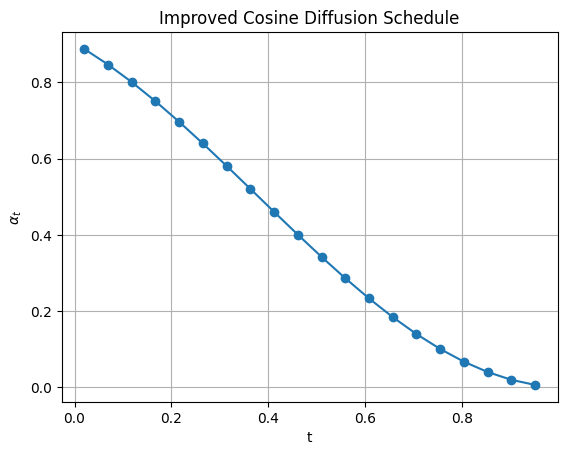

In [ ]:
t_vec = tf.linspace(0.02, 0.95, 20)
_, sqrt_alpha_t_vec = diffusion_schedule(t_vec)
alpha_t_vec = tf.math.square(sqrt_alpha_t_vec)

print(f"Shape of t_vec: {t_vec.shape}. Shape of alpha_t_vec: {alpha_t_vec.shape}.")

# Plot the schedule to check the behavior
plt.plot(t_vec, alpha_t_vec, 'o-')
plt.grid()
plt.xlabel('t')
plt.ylabel(r'$\alpha_t$')
plt.title("Improved Cosine Diffusion Schedule")
plt.show()

## The DiffusionModel
Everything joined together gives the Diffusion Model class.

In [ ]:
class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = get_network(image_size, widths, block_depth)
        self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        # the exponential moving average weights are used at evaluation
        if training:
            network = self.network
        else:
            network = self.ema_network

        # predict noise component and calculate the image component using it
        pred_noises = network([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # this new noisy image will be used in the next step

        return pred_images

    def generate(self, num_images, diffusion_steps):
        # noise -> images -> denormalized images
        initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, 3))
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(images, pred_images)  # only used as metric

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(0.999 * ema_weight + (1 - 0.999) * weight)

        return {m.name: m.result() for m in self.metrics[:-1]}

In [ ]:
# Define the parametters for the model
widths = [32, 64, 96, 128]
block_depth = 2

# create and compile the model
model = DiffusionModel(image_size, widths, block_depth)

# Optimizer specifications
learning_rate = 1e-3
weight_decay = 1e-4

model.compile(
    optimizer=keras.optimizers.experimental.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
# pixelwise mean absolute error is used as loss

# calculate mean and variance of training dataset for normalization
model.normalizer.adapt(train_dataset)

# run training and plot generated images periodically
model.fit(
    train_dataset,
    epochs=num_epochs,
    batch_size=batch_size,
)

Epoch 1/50
85/85 [==============================] - 42s 169ms/step - n_loss: 0.3323
Epoch 2/50
85/85 [==============================] - 15s 172ms/step - n_loss: 0.2080
Epoch 3/50
85/85 [==============================] - 15s 174ms/step - n_loss: 0.1920
Epoch 4/50
85/85 [==============================] - 15s 174ms/step - n_loss: 0.1807
Epoch 5/50
85/85 [==============================] - 15s 173ms/step - n_loss: 0.1822
Epoch 6/50
85/85 [==============================] - 15s 172ms/step - n_loss: 0.1736
Epoch 7/50
85/85 [==============================] - 15s 172ms/step - n_loss: 0.1738
Epoch 8/50
85/85 [==============================] - 15s 172ms/step - n_loss: 0.1704
Epoch 9/50
85/85 [==============================] - 15s 172ms/step - n_loss: 0.1691
Epoch 10/50
85/85 [==============================] - 15s 172ms/step - n_loss: 0.1658
Epoch 11/50
85/85 [==============================] - 15s 173ms/step - n_loss: 0.1680
Epoch 12/50
85/85 [==============================] - 15s 172ms/step - n_lo

### Generate new images

In [ ]:
# Generate num_images samples.
x_T = tf.random.normal(shape=(num_images, image_size, image_size, 3))
x_0 = model.reverse_diffusion(x_T, diffusion_steps)
x_0 = model.denormalize(x_0)

NameError: ignored

In [16]:
def plot_images(model, num_rows=3, num_cols=6, plot_diffusion_steps=20):
    # plot random generated images for visual evaluation of generation quality
    generated_images = model.generate(
        num_images=num_rows * num_cols,
        diffusion_steps=plot_diffusion_steps,
    )

    plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
    for row in range(num_rows):
        for col in range(num_cols):
            index = row * num_cols + col
            plt.subplot(num_rows, num_cols, index + 1)
            plt.imshow(generated_images[index])
            plt.axis("off")
    plt.tight_layout()
    plt.show()
    plt.close()